# SUBMISSION with RAPIDS TfidfVectorizer
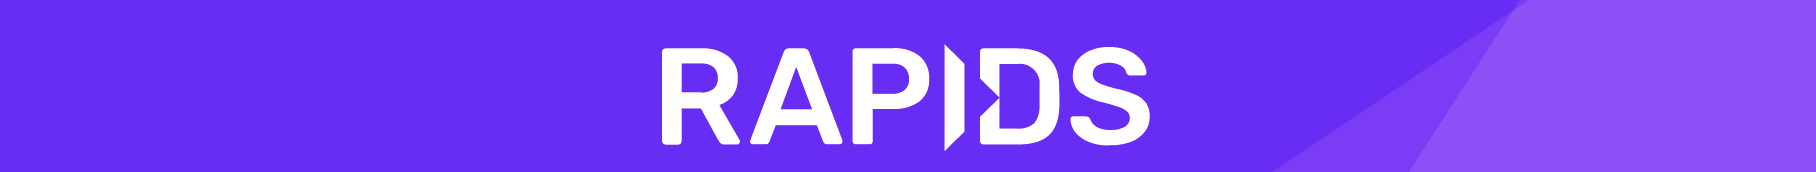

In my first notebook [here][1], we do some EDA and explain our solution approach which is to use both images and text with RAPIDS to find similar items. This notebook optimizes GPU memory so submission notebook will be successful. We also calculate the CV score (if the notebook is committed but not when submitted). If you haven't read my first [notebook, read][1] that first. You can learn more about RAPIDS [here][2] and [here][3]

**Note**: This **committed** notebook computes CV score but when we **submit** this notebook it does **not** compute CV. Instead it will load the 70,000 row `test.csv` file and compute matches in the test dataset. Because the variable `COMPUTE_CV = True` when we **commit** this notebook. But when we **submit** this notebook to Kaggle then the length of `test.csv` will be longer than 3 and the `if-statement` below will change to `COMPUTE_CV=False`. 

[1]: https://www.kaggle.com/cdeotte/rapids-cuml-tfidfvectorizer-and-knn
[2]: https://rapids.ai/start.html
[3]: https://docs.rapids.ai/api

# Load Libraries

In [ ]:
import numpy as np, pandas as pd, gc
import cv2, matplotlib.pyplot as plt
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
print('RAPIDS',cuml.__version__)
print('TF',tf.__version__)

In [ ]:
# RESTRICT TENSORFLOW TO 1GB OF GPU RAM
# SO THAT WE HAVE 15GB RAM FOR RAPIDS
LIMIT = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print('We will restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('then RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

# Load Train Data
First we load the train data and create a target column of ground truths to help us compute CV score. Note how the variable `COMPUTE_CV` will change to `False` when we **submit** this notebook but it is `True` now because you are reading a **commit** notebook.

In [ ]:
COMPUTE_CV = True

test = pd.read_csv('../input/shopee-product-matching/test.csv')
if len(test)>3: COMPUTE_CV = False
else: print('this submission notebook will compute CV score, but commit notebook will not')

In [ ]:
from sklearn.model_selection import train_test_split
train = pd.read_csv('../input/shopee-product-matching/train.csv')
train, test = train_test_split(train, test_size=.1, random_state=50)
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)
print('train shape is', train.shape )
train.head()

# Compute Baseline CV Score
A baseline is to predict all items with the same `image_phash` as being duplicate. Let's calcuate the CV score for this submission.

In [ ]:
tmp = train.groupby('image_phash').posting_id.agg('unique').to_dict()
train['oof'] = train.image_phash.map(tmp)

In [ ]:
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

In [ ]:
train['f1'] = train.apply(getMetric('oof'),axis=1)
print('CV score for baseline =',train.f1.mean())

# Compute RAPIDS Model CV and Infer Submission
We will now use image embeddings, text embeddings, and phash to create a better model with better CV. We will also infer submission csv.

Note how the variable `COMPUTE_CV` is only `True` when we **commit** this notebook. Right now you are reading a **commit** notebook, so we see test replaced with train and computed CV score. When we **submit** this notebook, the variable `COMPUTE_CV` will be `False` and the **submit** notebook will **not** compute CV. Instead it will load the real test dataset with 70,000 rows and find duplicates in the real test dataset.

In [ ]:
if COMPUTE_CV:
#    test = pd.read_csv('../input/shopee-product-matching/train.csv')
    test_gf = cudf.DataFrame(test)
    print('Using train as test to compute CV (since commit notebook). Shape is', test_gf.shape )
else:
    test = pd.read_csv('../input/shopee-product-matching/test.csv')
    test_gf = cudf.read_csv('../input/shopee-product-matching/test.csv')
    print('Test shape is', test_gf.shape )
test_gf.head()

# Use Image Embeddings
To prevent memory errors, we will compute image embeddings in chunks. And we will find similar images with RAPIDS cuML KNN in chunks.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=''): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path+row.image)
            X[i,] = cv2.resize(img,(self.img_size,self.img_size)) #/128.0 - 1.0
        return X

In [ ]:
BASE = '../input/shopee-product-matching/test_images/'
if COMPUTE_CV: BASE = '../input/shopee-product-matching/train_images/'

WGT = '../input/effnetb0/efficientnetb0_notop.h5'
model = EfficientNetB0(weights=WGT,include_top=False, pooling='avg', input_shape=None)

embeds = []
CHUNK = 1024*4

print('Computing image embeddings...')
CTS = len(test)//CHUNK
if len(test)%CHUNK!=0: CTS += 1
for i,j in enumerate( range( CTS ) ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test))
    print('chunk',a,'to',b)
    
    test_gen = DataGenerator(test.iloc[a:b], batch_size=32, path=BASE)
    image_embeddings = model.predict(test_gen,verbose=1,use_multiprocessing=True, workers=4)
    embeds.append(image_embeddings)

    #if i>=1: break
    
del model
_ = gc.collect()
image_embeddings = np.concatenate(embeds)
print('image embeddings shape',image_embeddings.shape)

In [ ]:
KNN = 50
if len(test)==3: KNN = 2
model = NearestNeighbors(n_neighbors=KNN)
model.fit(image_embeddings)

In [ ]:
preds = []
CHUNK = 1024*4

print('Finding similar images...')
CTS = len(image_embeddings)//CHUNK
if len(image_embeddings)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(image_embeddings))
    print('chunk',a,'to',b)
    distances, indices = model.kneighbors(image_embeddings[a:b,])
    
    for k in range(b-a):
        IDX = np.where(distances[k,]<6.0)[0]
        IDS = indices[k,IDX]
        o = test.iloc[IDS].posting_id.values
        preds.append(o)
        
del model, distances, indices, image_embeddings, embeds
_ = gc.collect()

In [ ]:
test['preds2'] = preds
test.head()

# Use Text Embeddings
To prevent memory errors, we will find similar titles in chunks. To faciliate this, we will use cosine similarity between text embeddings instead of KNN.

In [ ]:
print('Computing text embeddings...')
model = TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
text_embeddings = model.fit_transform(test_gf.title).toarray()
print('text embeddings shape',text_embeddings.shape)

In [ ]:
preds = []
CHUNK = 1024*4

print('Finding similar titles...')
CTS = len(test)//CHUNK
if len(test)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test))
    print('chunk',a,'to',b)
    
    # COSINE SIMILARITY DISTANCE
    cts = cupy.matmul( text_embeddings, text_embeddings[a:b].T).T
    
    for k in range(b-a):
        IDX = cupy.where(cts[k,]>0.7)[0]
        o = test.iloc[cupy.asnumpy(IDX)].posting_id.values
        preds.append(o)
        
del model, text_embeddings
_ = gc.collect()

In [ ]:
test['preds'] = preds
test.head()

# Use Phash Feature
We will predict all items with the same phash as duplicates

In [ ]:
tmp = test.groupby('image_phash').posting_id.agg('unique').to_dict()
test['preds3'] = test.image_phash.map(tmp)
test.head()

# Compute CV Score
This simple model scores a high CV of 0.700+!

In [ ]:
def combine_for_sub(row):
    x = np.concatenate([row.preds,row.preds2, row.preds3])
    return ' '.join( np.unique(x) )

def combine_for_cv(row):
    x = np.concatenate([row.preds,row.preds2, row.preds3])
    return np.unique(x)

In [ ]:
if COMPUTE_CV:
    tmp = test.groupby('label_group').posting_id.agg('unique').to_dict()
    test['target'] = test.label_group.map(tmp)
    test['oof'] = test.apply(combine_for_cv,axis=1)
    test['f1'] = test.apply(getMetric('oof'),axis=1)
    print('CV Score =', test.f1.mean() )

test['matches'] = test.apply(combine_for_sub,axis=1)

# Write Submission CSV
In this notebook, the submission file below looks funny containing train information. But when we submit this notebook, the size of `test.csv` dataframe will be longer than 3 rows and the variable `COMPUTE_CV` will subsequently set to `False`. Then our submission notebook will compute the correct matches using the real test dataset and our submission csv for LB will be ok.

In [ ]:
test[['posting_id','matches']].to_csv('submission.csv',index=False)
sub = pd.read_csv('submission.csv')
sub.head()